## Download necessary package

In [4]:
!pip install gensim vncorenlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 43.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 84.1 MB/s eta 0:00:00
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645933 sha256=2b53c157fdbcd5235823772fff9d2ed37f533d38aeeed59a467caa39a2721efd
  Stored in directory: /root/.cache/pip/wheels/6f/19/20/ec7083125fd06db1a19d0d3ca18806ecf4e8ed1464713b4efa
Successfully built vncorenlp


In [2]:
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

--2025-12-29 08:43:30--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.1.1.jar’

VnCoreNLP-1.1.1.jar 100%[===================>]  26.14M  --.-KB/s    in 0.1s    

2025-12-29 08:43:31 (241 MB/s) - ‘VnCoreNLP-1.1.1.jar’ saved [27412575/27412575]

--2025-12-29 08:43:31--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respon

In [3]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.vi.300.vec.gz
!gunzip cc.vi.300.vec.gz

--2025-12-29 08:43:31--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.vi.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.249.182.62, 13.249.182.81, 13.249.182.39, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.249.182.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1235219084 (1.1G) [binary/octet-stream]
Saving to: ‘cc.vi.300.vec.gz’

cc.vi.300.vec.gz    100%[===================>]   1.15G  49.1MB/s    in 9.1s    

2025-12-29 08:43:41 (129 MB/s) - ‘cc.vi.300.vec.gz’ saved [1235219084/1235219084]



In [6]:
from tensorflow.keras.layers import Input, Embedding, Dense, SimpleRNN, Bidirectional, LSTM, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras.models import load_model, Model
from sklearn.utils import class_weight
from gensim.models import KeyedVectors
from vncorenlp import VnCoreNLP
import matplotlib.pyplot as plt
from keras import layers
from google import colab
import pandas as pd
import numpy as np

In [8]:
colab.drive.mount('/content/drive')
base = "/content/drive/MyDrive/CS221-NLP/Project"

Mounted at /content/drive


## Load data and word embedding

In [11]:
base = "/content/drive/MyDrive/CS221-NLP/Project"

rdrsegmenter = VnCoreNLP("./vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')
def preprocess(text):
    tokens = rdrsegmenter.tokenize(text)
    return " ".join(token for token in tokens[0])

data = pd.read_csv(base + "/Dataset/vsa_food_rv_train_clean.csv", encoding="utf-8")
data['Comment'] = data['Comment'].apply(preprocess)
X = data["Comment"]
y = data["Rating"]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2020, test_size=0.2, stratify = y)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((10326,), (10326,), (2582,), (2582,))

In [17]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: np.float64(1.9638645872955496), 1: np.float64(0.6707808236975445)}


In [18]:
texts = X_train.astype(str).tolist()
labels = y_train.tolist()

texts_tokenized = [t.split() for t in texts]

tokenizer = Tokenizer(oov_token="<UNK>")
tokenizer.fit_on_texts(texts_tokenized)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

print("Số lượng từ trong vocab:", len(word_index))

Số lượng từ trong vocab: 17806


In [19]:
#Padding để tất cả các câu có cùng độ dài, đảm bảo các tensor có cùng kích thước
sequences = tokenizer.texts_to_sequences(texts_tokenized)
max_len = max(len(seq) for seq in sequences)
X_train = pad_sequences(sequences, maxlen=max_len, padding='post')
print("Chiều dài dài nhất: ", max_len)

Chiều dài dài nhất:  875


In [20]:
texts_test = X_test.astype(str).tolist()
labels_test = y_test.tolist()
texts_test_tokenized = [t.split() for t in texts_test]
sequences_test = tokenizer.texts_to_sequences(texts_test_tokenized)
X_test = pad_sequences(sequences_test, maxlen=max_len, padding='post')

In [21]:
ft_model = KeyedVectors.load_word2vec_format("cc.vi.300.vec", limit=50000)
embedding_dim = ft_model.vector_size
print("Số chiều embedding: ", embedding_dim)

Số chiều embedding:  300


In [22]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim)) #+1 dòng padding để index từ 1 - N
inft = 0
not_inft = 0
for word, i in word_index.items():
    if word in ft_model:
        embedding_matrix[i] = ft_model[word]
        inft += 1
    else:
        # Nếu từ không có trong FastText, gán vector ngẫu nhiên
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))
        not_inft += 1
print("Số từ có trong FastText: ", inft)
print("Số từ không có trong FastText: ", not_inft)

Số từ có trong FastText:  6540
Số từ không có trong FastText:  11266


## Define model architecture

In [51]:
class RNN:
  def __init__(self):
    return None

  def build(self):
    input = Input(shape = (max_len,))
    # Embeeding(dict_len, emb_len, weights)
    embedding = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],trainable=True)(input)
    hidden1 = SimpleRNN(128, return_sequences=True)(embedding)
    dropout1 = Dropout(0.1)(hidden1)
    hidden2 = SimpleRNN(64, return_sequences=True)(dropout1)
    dropout2 = Dropout(0.1)(hidden2)
    hidden3 = SimpleRNN(32)(dropout2)
    output = Dense(1, activation = 'sigmoid')(hidden3)
    self.model = Model(input, output)

  def train(self, x_train, y_train, model_file, epochs=5, batch_size=64, validation_split=0.2):
    self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    checkpoint = ModelCheckpoint(model_file, monitor='val_loss', save_best_only=True, mode='min', verbose=1 )
    history = self.model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                             validation_split=validation_split, class_weight=class_weights,
                             callbacks = [checkpoint])
    return history

  def load(self, model_file):
    self.model = load_model(model_file)

  def save(self, model_file):
    self.model.save(model_file)

  def summary(self):
    self.model.summary()

  def predict(self, x_test):
    return self.model.predict(x_test)

In [38]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [55]:
class BiLSTM:
  def __init__(self):
    return None

  def build(self):
    input = Input(shape = (max_len,))
    # Embeeding(dict_len, emb_len, weights)
    embedding = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],trainable=True)(input)
    hidden1 = Bidirectional(LSTM(128, return_sequences=True))(embedding)
    dropout1 = Dropout(0.1)(hidden1)
    hidden2 = Bidirectional(LSTM(64, return_sequences=True))(dropout1)
    dropout2 = Dropout(0.1)(hidden2)
    hidden3 = Bidirectional(LSTM(32))(dropout2)
    output = Dense(1, activation = 'sigmoid')(hidden3)
    self.model = Model(input, output)

  def train(self, x_train, y_train, model_file, epochs=5, batch_size=64, validation_split=0.2):
    self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    checkpoint = ModelCheckpoint(model_file, monitor='val_loss', save_best_only=True, mode='min', verbose=1 )
    history = self.model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                             validation_split=validation_split, class_weight=class_weights,
                             callbacks = [checkpoint])
    return history

  def load(self, model_file):
    self.model = load_model(model_file)

  def save(self, model_file):
    self.model.save(model_file)

  def summary(self):
    self.model.summary()

  def predict(self, x_test):
    return self.model.predict(x_test)

In [54]:
class CNN_LSTM:
  def __init__(self):
    return None

  def build(self):
    input = Input(shape = (max_len,))
    # Embeeding(dict_len, emb_len, weights)
    embedding = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],trainable=True)(input)
    conv1 = Conv1D(128, 3, activation = 'relu')(embedding)
    dropout = Dropout(0.1)(conv1)
    pool = MaxPooling1D(2)(dropout)
    lstm = LSTM(32)(pool)
    output = Dense(1, activation = 'sigmoid')(lstm)
    self.model = Model(input, output)

  def train(self, x_train, y_train, model_file, epochs=5, batch_size=64, validation_split=0.2):
    self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    checkpoint = ModelCheckpoint(model_file, monitor='val_loss', save_best_only=True, mode='min', verbose=1 )
    history = self.model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                             validation_split=validation_split, class_weight=class_weights,
                             callbacks = [checkpoint])
    return history

  def load(self, model_file):
    self.model = load_model(model_file)

  def save(self, model_file):
    self.model.save(model_file)

  def summary(self):
    self.model.summary()

  def predict(self, x_test):
    return self.model.predict(x_test)

In [26]:
def plot_history(hist):
  plt.plot(hist.history['accuracy'], label='train acc')
  plt.plot(hist.history['val_accuracy'], label='val acc')
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()

  # Plot loss
  plt.plot(hist.history['loss'], label='train loss')
  plt.plot(hist.history['val_loss'], label='val loss')
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()

## Training

In [43]:
rnn_path = base + "/Model/rnn_vncore.h5"
bilstm_path = base + "/Model/biLSTM_vncore.h5"
cnn_lstm_path = base + "/Model/cnn_lstm_vncore.h5"

In [52]:
rnn = RNN()
rnn.build()
rnn.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 875)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_7 (Embedding)         │ (None, 875, 300)       │     5,342,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_9 (SimpleRNN)        │ (None, 875, 128)       │        54,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 875, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_10 (SimpleRNN)       │ (None, 875, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 875, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_11 (SimpleRNN)       │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,412,501 (20.65 MB)

 Trainable params: 5,412,501 (20.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.5084 - loss: 0.7091
Epoch 1: val_loss improved from inf to 0.63145, saving model to /content/drive/MyDrive/CS221-NLP/Project/Model/rnn_vncore.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 37s 237ms/step - accuracy: 0.5085 - loss: 0.7090 - val_accuracy: 0.7406 - val_loss: 0.6314
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.5987 - loss: 0.6908
Epoch 2: val_loss did not improve from 0.63145
130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 204ms/step - accuracy: 0.5983 - loss: 0.6908 - val_accuracy: 0.7406 - val_loss: 0.6867
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.5061 - loss: 0.7000
Epoch 3: val_loss did not improve from 0.63145
130/130 ━━━━━━━━━━━━━━━━━━━━ 27s 204ms/step - accuracy: 0.5062 - loss: 0.6999 - val_accuracy: 0.7406 - val_loss: 0.6910
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.5622 - loss: 0.6953
Epoch 4: val_loss did not improve from 0.63145
130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 202ms/step - accuracy: 0.5619 - loss: 0.6953 - val_accuracy: 0.2594 - val_loss: 0.7131
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.4516 - loss: 0.6924
Epoch 5: val_loss did not i

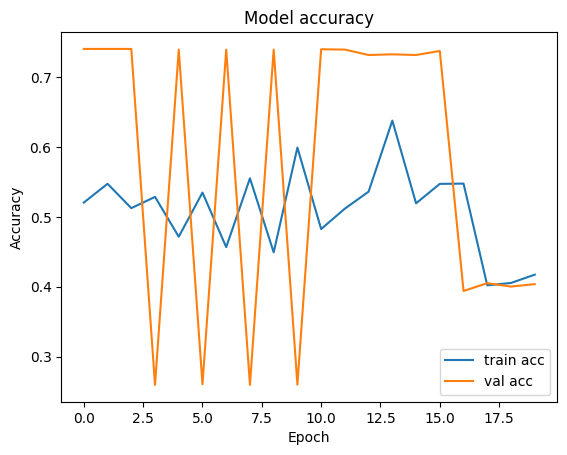

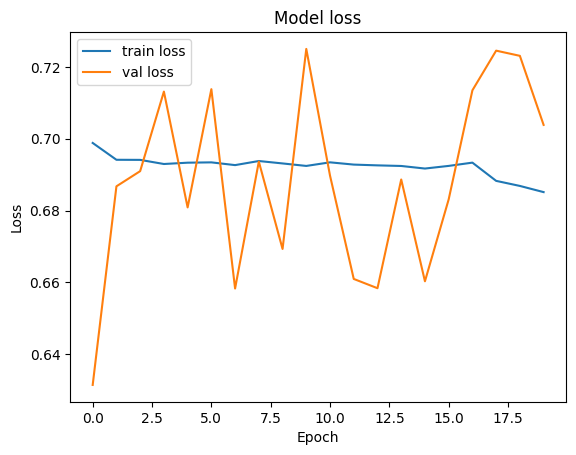

In [53]:
hist = rnn.train(X_train, y_train, rnn_path, epochs=20, batch_size=64)
plot_history(hist)

In [56]:
biLSTM = BiLSTM()
biLSTM.build()
biLSTM.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 875)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_8 (Embedding)         │ (None, 875, 300)       │     5,342,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 875, 256)       │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 875, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 875, 128)       │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 875, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,987,029 (22.84 MB)

 Trainable params: 5,987,029 (22.84 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.7015 - loss: 0.5595
Epoch 1: val_loss improved from inf to 0.50981, saving model to /content/drive/MyDrive/CS221-NLP/Project/Model/biLSTM_vncore.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 36s 243ms/step - accuracy: 0.7022 - loss: 0.5589 - val_accuracy: 0.8238 - val_loss: 0.5098
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.8861 - loss: 0.3568
Epoch 2: val_loss improved from 0.50981 to 0.32408, saving model to /content/drive/MyDrive/CS221-NLP/Project/Model/biLSTM_vncore.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 42s 248ms/step - accuracy: 0.8862 - loss: 0.3566 - val_accuracy: 0.8882 - val_loss: 0.3241
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.9296 - loss: 0.2482
Epoch 3: val_loss did not improve from 0.32408
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 239ms/step - accuracy: 0.9296 - loss: 0.2482 - val_accuracy: 0.8833 - val_loss: 0.3270
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9468 - loss: 0.1972
Epoch 4: val_loss did not improve from 0.32408
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 236ms/step - accuracy: 0.9468 - loss: 0.1972 - val_accuracy: 0.8921 - val_loss: 0.3251
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9534 - loss: 0.1586
Epoch 5: val_loss did not improve from 0.32408
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 237ms/step - accuracy: 0.9534 - loss: 0.1588 - val_accuracy: 0.8756 - val_loss: 0.3531
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9444 - loss: 0.1688
Epoch 6: val_loss did not i

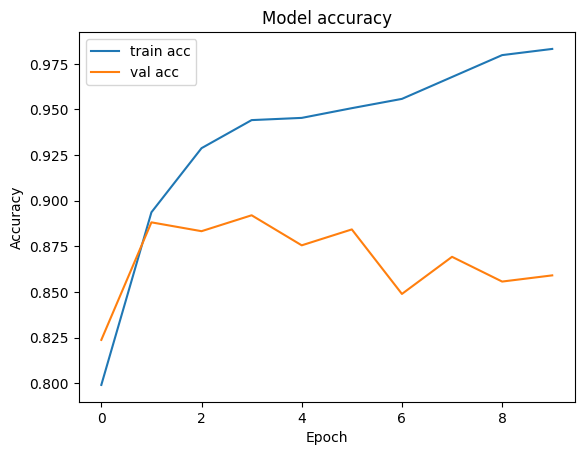

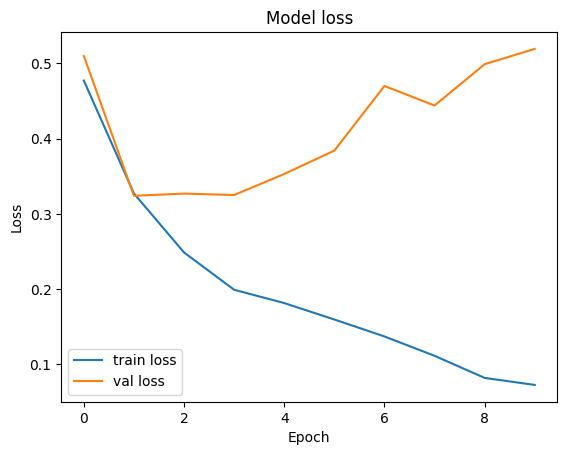

In [57]:
hist = biLSTM.train(X_train, y_train, bilstm_path,  epochs=10, batch_size=64)
plot_history(hist)

In [58]:
cnn_lstm = CNN_LSTM()
cnn_lstm.build()
cnn_lstm.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 875)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_9 (Embedding)         │ (None, 875, 300)       │     5,342,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 873, 128)       │       115,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 873, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 436, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,478,069 (20.90 MB)

 Trainable params: 5,478,069 (20.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5250 - loss: 0.6890
Epoch 1: val_loss improved from inf to 0.69897, saving model to /content/drive/MyDrive/CS221-NLP/Project/Model/cnn_lstm_vncore.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.5247 - loss: 0.6890 - val_accuracy: 0.2594 - val_loss: 0.6990
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4300 - loss: 0.6973
Epoch 2: val_loss improved from 0.69897 to 0.69200, saving model to /content/drive/MyDrive/CS221-NLP/Project/Model/cnn_lstm_vncore.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.4303 - loss: 0.6972 - val_accuracy: 0.7406 - val_loss: 0.6920
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5078 - loss: 0.6964
Epoch 3: val_loss improved from 0.69200 to 0.68938, saving model to /content/drive/MyDrive/CS221-NLP/Project/Model/cnn_lstm_vncore.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.5082 - loss: 0.6963 - val_accuracy: 0.7406 - val_loss: 0.6894
Epoch 4/20
129/130 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6232 - loss: 0.6919
Epoch 4: val_loss did not improve from 0.68938
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.6215 - loss: 0.6919 - val_accuracy: 0.7406 - val_loss: 0.6904
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5712 - loss: 0.6999
Epoch 5: val_loss improved from 0.68938 to 0.68552, saving model to /content/drive/MyDrive/CS221-NLP/Project/Model/cnn_lstm_vncore.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.5710 - loss: 0.6999 - val_accuracy: 0.7406 - val_loss: 0.6855
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5859 - loss: 0.6955
Epoch 6: val_loss did not improve from 0.68552
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.5848 - loss: 0.6955 - val_accuracy: 0.7406 - val_loss: 0.6896
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7445 - loss: 0.6861
Epoch 7: val_loss did not improve from 0.68552
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.7444 - loss: 0.6861 - val_accuracy: 0.7406 - val_loss: 0.6925
Epoch 8/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7515 - loss: 0.6875
Epoch 8: val_loss did not improve from 0.68552
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.7515 - loss: 0.6876 - val_accuracy: 0.2594 - val_loss: 0.6932
Epoch 9/20
129/130 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2718 - loss: 0.6967
Epoch 9: val_loss did not improve from 

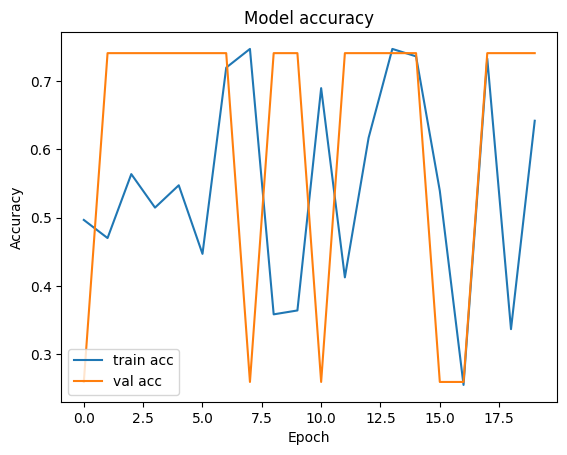

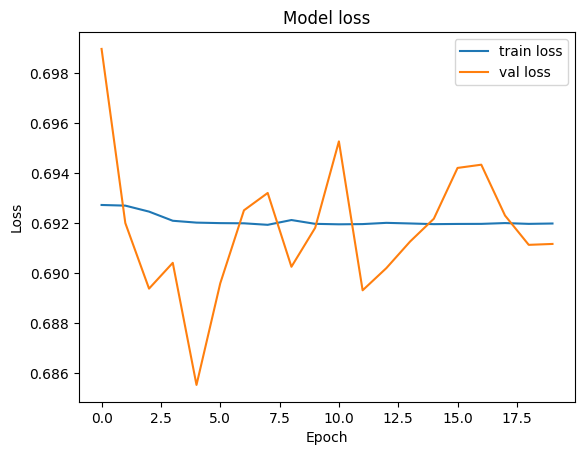

In [59]:
hist = cnn_lstm.train(X_train, y_train, cnn_lstm_path, epochs=20, batch_size=64)
plot_history(hist)

## Testing

In [60]:
rnn.load(rnn_path)
biLSTM.load(bilstm_path)
cnn_lstm.load(cnn_lstm_path)

In [61]:
rnn_predicted = rnn.predict(X_test)
biLSTM_predicted = biLSTM.predict(X_test)
cnn_lstm_predicted = cnn_lstm.predict(X_test)

81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [62]:
rnn_predicted = np.round(rnn_predicted)
biLSTM_predicted = np.round(biLSTM_predicted)
cnn_lstm_predicted = np.round(cnn_lstm_predicted)

              precision    recall  f1-score   support

         0.0       0.50      0.00      0.00       657
         1.0       0.75      1.00      0.85      1925

    accuracy                           0.75      2582
   macro avg       0.62      0.50      0.43      2582
weighted avg       0.68      0.75      0.64      2582



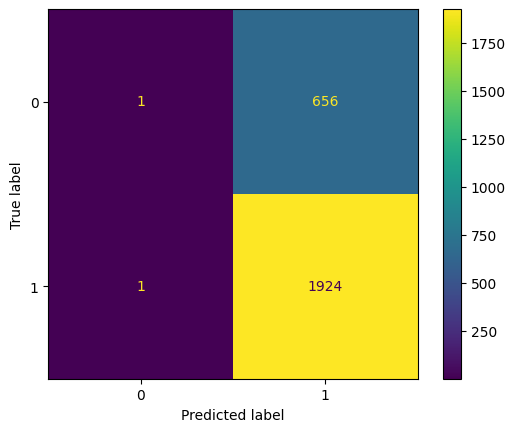

In [63]:
print(classification_report(y_test, rnn_predicted))
cm = confusion_matrix(y_test, rnn_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

              precision    recall  f1-score   support

         0.0       0.79      0.81      0.80       657
         1.0       0.93      0.93      0.93      1925

    accuracy                           0.90      2582
   macro avg       0.86      0.87      0.86      2582
weighted avg       0.90      0.90      0.90      2582



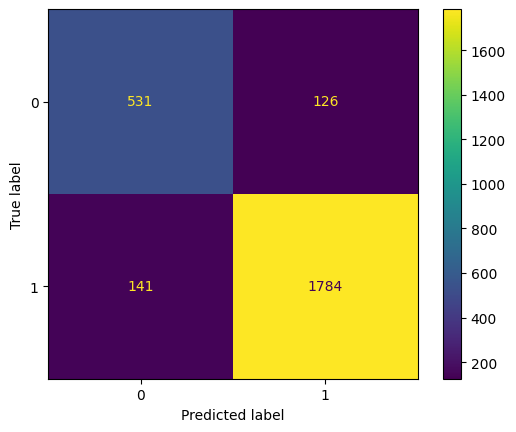

In [64]:
print(classification_report(y_test, biLSTM_predicted))
cm = confusion_matrix(y_test, biLSTM_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       657
         1.0       0.75      1.00      0.85      1925

    accuracy                           0.75      2582
   macro avg       0.37      0.50      0.43      2582
weighted avg       0.56      0.75      0.64      2582



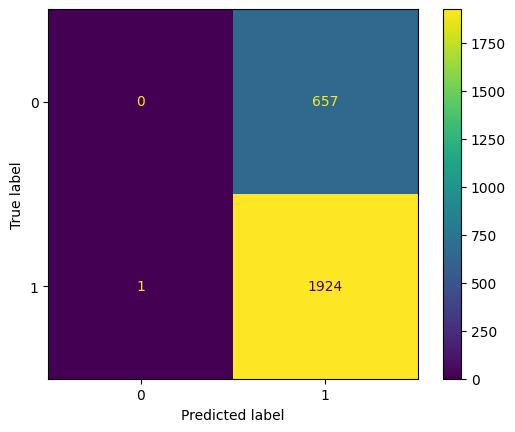

In [65]:
print(classification_report(y_test, cnn_lstm_predicted))
cm = confusion_matrix(y_test, cnn_lstm_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()